### Import required packages and limit GPU usage

In [27]:
import numpy as np
import math
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv

# Import the module
import networks
import utils
from quantize_neural_net import QuantizeNeuralNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [29]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [30]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student_nokd = 'checkpoints_student/checkpoints_student_NoKD/'
checkpoints_path_student_van = 'checkpoints_student/checkpoints_student_VAN/'
checkpoints_path_student_qat = 'checkpoints_student/checkpoints_student_QAT/'
checkpoints_path_student_dml = 'checkpoints_student/checkpoints_student_DML/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student_nokd):
    os.makedirs(checkpoints_path_student_nokd)
if not os.path.exists(checkpoints_path_student_van):
    os.makedirs(checkpoints_path_student_van)
if not os.path.exists(checkpoints_path_student_qat):
    os.makedirs(checkpoints_path_student_qat)
if not os.path.exists(checkpoints_path_student_dml):
    os.makedirs(checkpoints_path_student_dml)

### Load dataset

In [31]:
import torchvision
import torchvision.transforms as transforms
import PIL

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

import torchvision as tv
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)

In [33]:
def calculate_bit_size(model):
    """
    Calculate the effective bit size of a quantized model.
    
    Parameters:
        model: nn.Module
            The quantized neural network model.
    
    Returns:
        float: The average bit size across all layers.
    """
    total_bits = 0
    total_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Calculate unique values and their count
            unique_values = torch.unique(param.data).cpu().numpy()
            num_unique_values = len(unique_values)
            
            # Calculate bit size for this layer
            layer_bits = np.ceil(np.log2(num_unique_values)) if num_unique_values > 1 else 1
            total_bits += layer_bits * param.numel()
            total_params += param.numel()
    
    # Return average bit size across all parameters
    return total_bits / total_params if total_params > 0 else 0


In [34]:
def scalar(bits):
    if 26<bits <=32:
        return 3.5
    elif 20< bits <= 26:
        return 3
    elif 16< bits <= 20:
        return 2.5
    elif 8< bits <= 16:
        return 2
    elif 4< bits <= 8:
        return 1.5
    elif 3< bits <= 4:
        return 1.16
    else:
        return 0.5 # only for student 2-3 bits

## Teacher Model

### load pre-trained teacher model

In [35]:
import detectors
import timm

teacher_net = timm.create_model("resnet50_cifar10", pretrained=True)

teacher_net = teacher_net.to(fast_device)
# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)


test accuracy:  0.9225


In [36]:
# another way load teacher
teacher_net = networks.TeacherNetwork50()

checkpoint = torch.load('resnet50_cifar10_pretrained.bin')

teacher_net.model.load_state_dict(checkpoint)
teacher_net.to(fast_device)

reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_13896\1025170478.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling

test accuracy:  0.9225


### Quantized Teacher Model

In [12]:
# Quantization CSV file setup
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Effective Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Sparsity", "Training Time (s)"])

In [21]:
csv_file = "checkpoints_teacher/results_teacher_quantization.csv"
range1 = range(32, 20, -6)
range2= range(20, 8, -4) 
range3= range(8, 4, -2)
range4= range(4, 1, -1)
bits_list = list(range1) + list(range2) + list(range3) + list(range4)
bits_list= range(3, 1, -1)
for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        teacher_net.model,
        'resnet50',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar= 1.16, # scalar(bits)
        cnn_alphabet_scalar= 1.16, #scalar(bits),
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network(False)

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 
    sparsity = utils.eval_sparsity(quantized_model)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, effective_bit_size, 0.9225, quantized_test_accuracy, sparsity,  training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 376.94it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 237.58it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2605.75it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.73it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 190.80it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 415.56it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2813.72it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 192.67it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 408.33it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2759.54it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 174.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 199.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1784.81it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 527.43it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 58.94it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1746.15it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2875.33it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 641.85it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1623.17it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2938.22it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 644.64it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1719.24it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2929.76it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 686.87it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 977.19it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2873.10it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1157.44it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 337.51it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2260.03it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3331.22it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1155.53it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2209.61it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3185.93it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1177.76it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2295.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3380.12it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1093.95it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2297.50it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3488.59it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1132.22it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2323.98it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3140.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1129.69it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1753.14it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2438.82it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1345.34it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 578.69it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2876.85it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3392.32it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1598.78it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2866.58it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3442.41it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1681.78it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3430.42it/s]


Bits 3, Effective Quantized Bit Size: 4.012658050251773
Bits 3, Quantized Test Accuracy: 0.9129
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 340.34it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 161.77it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2636.98it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 185.98it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 194.11it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 425.18it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2918.74it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 188.21it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 430.02it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2753.38it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 189.31it/s]


The number of groups: 1



100%|██████████| 256/256 [00:01<00:00, 225.18it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2281.43it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 667.82it/s]


The number of groups: 1



100%|██████████| 256/256 [00:04<00:00, 60.54it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1686.16it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3116.32it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 678.24it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1694.08it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2970.08it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 658.98it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1677.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3402.85it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 677.16it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1053.52it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2927.75it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1136.97it/s]


The number of groups: 1



100%|██████████| 512/512 [00:01<00:00, 341.34it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2288.79it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3479.00it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1155.86it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2365.03it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3477.78it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.07it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2364.77it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3431.34it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1151.29it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2360.07it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3380.55it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1159.92it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2336.78it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3549.05it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1190.69it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 1724.24it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3252.10it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1729.06it/s]


The number of groups: 1



100%|██████████| 1024/1024 [00:01<00:00, 657.67it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2963.33it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3473.53it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1708.93it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3007.67it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3439.15it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1730.51it/s]


The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3389.46it/s]


Bits 2, Effective Quantized Bit Size: 3.0149168979579897
Bits 2, Quantized Test Accuracy: 0.909
Results saved to checkpoints_teacher/results_teacher_quantization.csv


## Student Network

#### Without KD 

In [73]:
num_epochs = 20
print_every = 100
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [0.0] # only use label for training
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_nokd = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_nokd + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill_nokd[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_nokd
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_nokd + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_nokd[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0
0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 1.450 train accuracy: 0.453
[1,   200/  372] train loss: 0.954 train accuracy: 0.703
[1,   300/  372] train loss: 0.751 train accuracy: 0.758
epoch: 1 validation accuracy: 0.742
[2,   100/  372] train loss: 0.602 train accuracy: 0.773
[2,   200/  372] train loss: 0.441 train accuracy: 0.852
[2,   300/  372] train loss: 0.438 train accuracy: 0.852
epoch: 2 validation accuracy: 0.826
[3,   100/  372] train loss: 0.491 train accuracy: 0.828
[3,   200/  372] train loss: 0.349 train accuracy: 0.883
[3,   300/  372] train loss: 0.368 train accuracy: 0.875
epoch: 3 validation accuracy: 0.862
[4,   100/  372] train loss: 0.361 train accuracy: 0.898
[4,   200/  372] train loss: 0.385 train accuracy: 0.867
[4,   300/  372] train loss: 0.267 train accuracy: 0.891

In [21]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Effective Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Sparsity", "Training Time (s)"])

In [22]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_NoKD/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

csv_file = "checkpoints_student/checkpoints_student_nokd/results_student_quantization.csv"

C:\Users\17598\AppData\Local\Temp\ipykernel_14284\2355955617.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

In [28]:
# Create two range objects
range1 = range(32, 16,-4)
range2= range(16, 8, -2)
range3= range(8, 0, -1)
bits_list = list(range1) + list(range2) + list(range3)

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=3.5,
        cnn_alphabet_scalar=3.5,
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network(False)

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    sparsity = utils.eval_sparsity(quantized_model)

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits,effective_bit_size, 0.8891, quantized_test_accuracy,sparsity, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 253.23it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2422.05it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2139.09it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2112.42it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2172.35it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1704.79it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3005.22it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 316.26it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2640.52it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3167.43it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2429.40it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3195.55it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 859.70it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3000.23it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3172.93it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2977.87it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3095.73it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1139.21it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3133.13it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3160.62it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2984.59it/s]


Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.8648
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 339.48it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 928.57it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2431.27it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2365.32it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2251.74it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1433.02it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2726.07it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 309.30it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3185.07it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3039.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2413.48it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2648.51it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 816.46it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3323.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3250.70it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2839.58it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2970.47it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1474.22it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3119.58it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2798.12it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2835.13it/s]


Bits 28, Effective Quantized Bit Size: 21.121295382962643
Bits 28, Quantized Test Accuracy: 0.8839
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 295.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 877.34it/s] 


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2386.66it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2046.57it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2110.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1687.27it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2871.82it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 330.39it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2335.49it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3155.10it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2422.64it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3276.43it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 917.68it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2605.33it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3081.94it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2697.22it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2834.13it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1073.28it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2734.81it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2882.14it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3695.13it/s]


Bits 24, Effective Quantized Bit Size: 20.223940621956654
Bits 24, Quantized Test Accuracy: 0.8746
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 353.50it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1371.96it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2667.69it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2793.83it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2443.84it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1828.68it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3415.23it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 352.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3612.95it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3634.16it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2841.29it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3211.72it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1081.01it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3541.97it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3603.05it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3207.15it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3062.22it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1356.89it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3115.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3275.76it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3214.64it/s]


Bits 20, Effective Quantized Bit Size: 17.898076259790393
Bits 20, Quantized Test Accuracy: 0.8651
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 366.28it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 953.86it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2663.77it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2696.33it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2251.75it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1928.76it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3096.66it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 352.20it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3251.74it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3623.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2729.39it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3666.10it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 983.42it/s] 


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3319.87it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3402.21it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3247.02it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3216.46it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1581.97it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3591.94it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3513.91it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3683.69it/s]


Bits 16, Effective Quantized Bit Size: 14.82808192832587
Bits 16, Quantized Test Accuracy: 0.8572
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 398.25it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1515.24it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2880.01it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2873.82it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2576.53it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1528.56it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3220.64it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 346.78it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3497.85it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3118.76it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2353.56it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3446.54it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 907.32it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3805.05it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3649.74it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3398.35it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3380.69it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1647.82it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3705.84it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3638.01it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2915.65it/s]


Bits 14, Effective Quantized Bit Size: 13.354393007601065
Bits 14, Quantized Test Accuracy: 0.8773
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 283.15it/s]


The number of groups: 1



 27%|██▋       | 157/576 [00:00<00:01, 415.81it/s]


KeyboardInterrupt: 

### Vanilla

In [77]:
num_epochs = 20
print_every = 100

# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill_van = {}
pruning_factor = 0

# CSV file setup
csv_file = checkpoints_path_student_van + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
    student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(student_net)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))

    results_distill_van[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(
            teacher_net, student_net, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=False,
            checkpoint_save_path = checkpoints_path_student_van
        )

    training_time = time.time() - start_time

    # Final model save
    final_save_path = checkpoints_path_student_van + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill_van[(hparam_tuple, pruning_factor)],
        'model_state_dict': student_net.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 11173962 23520842
epoch: 0 validation accuracy: 0.110
[1,   100/  372] train loss: 5.777 train accuracy: 0.680
[1,   200/  372] train loss: 3.589 train accuracy: 0.797
[1,   300/  372] train loss: 2.916 train accuracy: 0.836
epoch: 1 validation accuracy: 0.858
[2,   100/  372] train loss: 1.893 train accuracy: 0.906
[2,   200/  372] train loss: 1.805 train accuracy: 0.953
[2,   300/  372] train loss: 1.338 train accuracy: 0.930
epoch: 2 validation accuracy: 0.888
[3,   100/  372] train loss: 1.538 train accuracy: 0.922
[3,   200/  372] train loss: 1.118 train accuracy: 0.930
[3,   300/  372] train loss: 1.191 train accuracy: 0.953
epoch: 3 validation accuracy: 0.901
[4,   100/  372] train loss: 1.134 train accuracy: 0.938
[4,   200/  372] train loss: 1.383 train accuracy: 0.938
[4,   300/  372] train loss: 0.837 train accuracy: 0.953
epoch: 4 validation accuracy: 0.907
[5,   100/  372] train loss: 0.899 train accuracy: 0.953
[5,   200/  372] train loss: 0.848 train accuracy: 0.977
[5

In [14]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_VAN/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_13896\4284167774.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

(0.0, 0.9152)

In [15]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [16]:
range1 = range(32, 20, -6)
range2= range(20, 8, -4) 
range3= range(8, 4, -2)
range4= range(4, 1, -1)
bits_list = list(range1) + list(range2) + list(range3) + list(range4)

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=scalar(bits),
        cnn_alphabet_scalar=scalar(bits),
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.9152, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 468.30it/s]

The quantization error of layer 0 is 2.36030864471104e-05.
The relative quantization error of layer 0 is 6.605812785664966e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2863.93it/s]


The quantization error of layer 1 is 2.864307680283673e-05.
The relative quantization error of layer 1 is 5.615928699853612e-08.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2645.69it/s]


The quantization error of layer 2 is 0.0018663207301869988.
The relative quantization error of layer 2 is 7.389583061012672e-06.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2349.21it/s]


The quantization error of layer 3 is 0.008297314867377281.
The relative quantization error of layer 3 is 1.575097667227965e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2146.54it/s]


The quantization error of layer 4 is 0.01427796296775341.
The relative quantization error of layer 4 is 7.784031186020002e-05.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1635.65it/s]


The quantization error of layer 5 is 0.07713501155376434.
The relative quantization error of layer 5 is 0.00011128201003884897.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2348.88it/s]


The quantization error of layer 6 is 0.017091138288378716.
The relative quantization error of layer 6 is 0.00010836483852472156.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 289.77it/s]


The quantization error of layer 7 is 0.06724771112203598.
The relative quantization error of layer 7 is 8.59245119499974e-05.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3011.38it/s]


The quantization error of layer 8 is 0.03573352470993996.
The relative quantization error of layer 8 is 0.00015179328329395503.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2007.77it/s]


The quantization error of layer 9 is 0.3910129964351654.
The relative quantization error of layer 9 is 0.004108721856027842.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1693.39it/s]


The quantization error of layer 10 is 1.1218458414077759.
The relative quantization error of layer 10 is 0.0029467481654137373.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2801.51it/s]


The quantization error of layer 11 is 0.2774665355682373.
The relative quantization error of layer 11 is 0.00226909713819623.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 639.06it/s]


The quantization error of layer 12 is 1.1822123527526855.
The relative quantization error of layer 12 is 0.005076434463262558.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2944.01it/s]


The quantization error of layer 13 is 0.2831265330314636.
The relative quantization error of layer 13 is 0.0015700763324275613.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3247.45it/s]


The quantization error of layer 14 is 0.25704264640808105.
The relative quantization error of layer 14 is 0.0043380726128816605.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2925.67it/s]


The quantization error of layer 15 is 1.8196834325790405.
The relative quantization error of layer 15 is 0.0073904008604586124.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3264.55it/s]


The quantization error of layer 16 is 0.26572462916374207.
The relative quantization error of layer 16 is 0.004299271386116743.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1478.81it/s]

The quantization error of layer 17 is 4.5316643714904785.
The relative quantization error of layer 17 is 0.027248134836554527.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2961.88it/s]


The quantization error of layer 18 is 2.9444611072540283.
The relative quantization error of layer 18 is 0.01611419953405857.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2896.83it/s]


The quantization error of layer 19 is 2.576486825942993.
The relative quantization error of layer 19 is 0.07378851622343063.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3291.79it/s]

The quantization error of layer 20 is 20.869115829467773.
The relative quantization error of layer 20 is 0.1517668515443802.



Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.9077
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 386.97it/s]

The quantization error of layer 0 is 2.510650119802449e-05.
The relative quantization error of layer 0 is 7.142136126958576e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1599.30it/s]


The quantization error of layer 1 is 3.1875162676442415e-05.
The relative quantization error of layer 1 is 6.238116867507415e-08.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2691.48it/s]


The quantization error of layer 2 is 0.0023221371229737997.
The relative quantization error of layer 2 is 9.217949809681159e-06.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2587.97it/s]


The quantization error of layer 3 is 0.008370032534003258.
The relative quantization error of layer 3 is 1.577568764332682e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2364.63it/s]


The quantization error of layer 4 is 0.013959144242107868.
The relative quantization error of layer 4 is 7.637334056198597e-05.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1679.64it/s]


The quantization error of layer 5 is 0.07520314306020737.
The relative quantization error of layer 5 is 0.0001093394384952262.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2855.19it/s]


The quantization error of layer 6 is 0.017280880361795425.
The relative quantization error of layer 6 is 0.00010739310528151691.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 347.11it/s]


The quantization error of layer 7 is 1.654805302619934.
The relative quantization error of layer 7 is 0.0021192256826907396.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3263.58it/s]


The quantization error of layer 8 is 0.24487829208374023.
The relative quantization error of layer 8 is 0.0010277826804667711.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3138.87it/s]


The quantization error of layer 9 is 0.20870441198349.
The relative quantization error of layer 9 is 0.0022163712419569492.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2585.00it/s]


The quantization error of layer 10 is 0.7008858323097229.
The relative quantization error of layer 10 is 0.0018530241213738918.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3289.70it/s]


The quantization error of layer 11 is 0.15397131443023682.
The relative quantization error of layer 11 is 0.0012669701827690005.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 885.80it/s]

The quantization error of layer 12 is 0.7141439914703369.
The relative quantization error of layer 12 is 0.003066528122872114.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2983.74it/s]


The quantization error of layer 13 is 0.1693495213985443.
The relative quantization error of layer 13 is 0.0009701083181425929.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2915.85it/s]


The quantization error of layer 14 is 0.08247531950473785.
The relative quantization error of layer 14 is 0.0013870905386283994.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2945.38it/s]


The quantization error of layer 15 is 0.4419059753417969.
The relative quantization error of layer 15 is 0.001810988294892013.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2724.49it/s]


The quantization error of layer 16 is 0.07231494039297104.
The relative quantization error of layer 16 is 0.001170000177808106.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1062.58it/s]


The quantization error of layer 17 is 3.404083490371704.
The relative quantization error of layer 17 is 0.020578565075993538.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2658.93it/s]


The quantization error of layer 18 is 2.2283501625061035.
The relative quantization error of layer 18 is 0.012283334508538246.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:02<00:00, 2254.08it/s]


The quantization error of layer 19 is 2.4780850410461426.
The relative quantization error of layer 19 is 0.06991027295589447.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1937.22it/s]


The quantization error of layer 20 is 18.315767288208008.
The relative quantization error of layer 20 is 0.13194690644741058.

Bits 26, Effective Quantized Bit Size: 20.487868492840768
Bits 26, Quantized Test Accuracy: 0.9077
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.66it/s]

The quantization error of layer 0 is 0.00038985462742857635.
The relative quantization error of layer 0 is 1.1130387065350078e-06.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2799.06it/s]


The quantization error of layer 1 is 0.0006373797077685595.
The relative quantization error of layer 1 is 1.2470223964555771e-06.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2850.55it/s]


The quantization error of layer 2 is 0.007059975061565638.
The relative quantization error of layer 2 is 2.7682017389452085e-05.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2708.31it/s]


The quantization error of layer 3 is 0.03110429085791111.
The relative quantization error of layer 3 is 5.91895732213743e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2448.62it/s]


The quantization error of layer 4 is 0.03084140457212925.
The relative quantization error of layer 4 is 0.00016925815725699067.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1973.61it/s]


The quantization error of layer 5 is 0.13884326815605164.
The relative quantization error of layer 5 is 0.0002011173201026395.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3177.45it/s]


The quantization error of layer 6 is 0.02474050037562847.
The relative quantization error of layer 6 is 0.00015650168643333018.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 342.09it/s]


The quantization error of layer 7 is 21.268274307250977.
The relative quantization error of layer 7 is 0.027239497750997543.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3068.31it/s]


The quantization error of layer 8 is 3.473527431488037.
The relative quantization error of layer 8 is 0.014517538249492645.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3273.35it/s]


The quantization error of layer 9 is 2.4825737476348877.
The relative quantization error of layer 9 is 0.02617497555911541.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2433.32it/s]


The quantization error of layer 10 is 8.485986709594727.
The relative quantization error of layer 10 is 0.022657575085759163.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3146.04it/s]


The quantization error of layer 11 is 1.8516674041748047.
The relative quantization error of layer 11 is 0.015218243934214115.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 846.27it/s]

The quantization error of layer 12 is 8.650568962097168.
The relative quantization error of layer 12 is 0.03723304718732834.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3066.13it/s]


The quantization error of layer 13 is 1.9689115285873413.
The relative quantization error of layer 13 is 0.011260324157774448.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3172.23it/s]


The quantization error of layer 14 is 0.9665667414665222.
The relative quantization error of layer 14 is 0.016051309183239937.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2742.25it/s]


The quantization error of layer 15 is 3.9064273834228516.
The relative quantization error of layer 15 is 0.016074908897280693.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3128.08it/s]


The quantization error of layer 16 is 0.6073002815246582.
The relative quantization error of layer 16 is 0.009635881520807743.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1402.91it/s]


The quantization error of layer 17 is 8.903268814086914.
The relative quantization error of layer 17 is 0.05387834459543228.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3208.04it/s]


The quantization error of layer 18 is 3.7123188972473145.
The relative quantization error of layer 18 is 0.02032514475286007.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3097.80it/s]


The quantization error of layer 19 is 2.7783260345458984.
The relative quantization error of layer 19 is 0.08140332251787186.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3072.21it/s]

The quantization error of layer 20 is 21.944419860839844.
The relative quantization error of layer 20 is 0.15984410047531128.



Bits 20, Effective Quantized Bit Size: 18.267575279028154
Bits 20, Quantized Test Accuracy: 0.9043
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 352.27it/s]


The quantization error of layer 0 is 0.005111537408083677.
The relative quantization error of layer 0 is 1.5037662706163246e-05.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1073.66it/s]


The quantization error of layer 1 is 0.08350162953138351.
The relative quantization error of layer 1 is 0.00016411887190770358.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2708.27it/s]


The quantization error of layer 2 is 0.19526876509189606.
The relative quantization error of layer 2 is 0.0007682752911932766.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2692.30it/s]


The quantization error of layer 3 is 0.6603153944015503.
The relative quantization error of layer 3 is 0.0012569476384669542.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2553.69it/s]


The quantization error of layer 4 is 0.31439661979675293.
The relative quantization error of layer 4 is 0.0017184874741360545.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1775.76it/s]


The quantization error of layer 5 is 0.7898777723312378.
The relative quantization error of layer 5 is 0.0011384824756532907.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3067.60it/s]


The quantization error of layer 6 is 0.12790459394454956.
The relative quantization error of layer 6 is 0.000800012843683362.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 347.74it/s]


The quantization error of layer 7 is 40.73300552368164.
The relative quantization error of layer 7 is 0.05229352042078972.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3232.78it/s]


The quantization error of layer 8 is 6.815683364868164.
The relative quantization error of layer 8 is 0.028628258034586906.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3194.65it/s]


The quantization error of layer 9 is 2.832270383834839.
The relative quantization error of layer 9 is 0.029669491574168205.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2280.21it/s]


The quantization error of layer 10 is 12.33023738861084.
The relative quantization error of layer 10 is 0.032719727605581284.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2726.57it/s]


The quantization error of layer 11 is 2.219709873199463.
The relative quantization error of layer 11 is 0.018339361995458603.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 745.79it/s]

The quantization error of layer 12 is 12.526009559631348.
The relative quantization error of layer 12 is 0.05379394069314003.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2083.48it/s]


The quantization error of layer 13 is 2.42484188079834.
The relative quantization error of layer 13 is 0.013645613566040993.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2339.98it/s]


The quantization error of layer 14 is 1.2309632301330566.
The relative quantization error of layer 14 is 0.02116083912551403.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2079.03it/s]


The quantization error of layer 15 is 5.597582817077637.
The relative quantization error of layer 15 is 0.022825364023447037.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2486.13it/s]


The quantization error of layer 16 is 0.8120697736740112.
The relative quantization error of layer 16 is 0.013208535499870777.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1821.37it/s]

The quantization error of layer 17 is 12.532596588134766.
The relative quantization error of layer 17 is 0.07512877136468887.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2949.21it/s]


The quantization error of layer 18 is 5.179078102111816.
The relative quantization error of layer 18 is 0.028661813586950302.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2925.61it/s]


The quantization error of layer 19 is 3.1343295574188232.
The relative quantization error of layer 19 is 0.08820817619562149.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2984.34it/s]


The quantization error of layer 20 is 24.578527450561523.
The relative quantization error of layer 20 is 0.17717735469341278.

Bits 16, Effective Quantized Bit Size: 15.57551099601019
Bits 16, Quantized Test Accuracy: 0.9026
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 325.69it/s]

The quantization error of layer 0 is 0.08316044509410858.
The relative quantization error of layer 0 is 0.00023359069018624723.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 914.53it/s]


The quantization error of layer 1 is 0.15455986559391022.
The relative quantization error of layer 1 is 0.00030271903960965574.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2114.05it/s]


The quantization error of layer 2 is 0.23636572062969208.
The relative quantization error of layer 2 is 0.0009314347989857197.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2288.67it/s]


The quantization error of layer 3 is 0.7346803545951843.
The relative quantization error of layer 3 is 0.0013932643923908472.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2364.48it/s]


The quantization error of layer 4 is 0.34344786405563354.
The relative quantization error of layer 4 is 0.0018673305166885257.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1818.67it/s]


The quantization error of layer 5 is 1.0086207389831543.
The relative quantization error of layer 5 is 0.001477147568948567.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2895.57it/s]


The quantization error of layer 6 is 0.17497780919075012.
The relative quantization error of layer 6 is 0.001099943183362484.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 296.64it/s]


The quantization error of layer 7 is 40.97596740722656.
The relative quantization error of layer 7 is 0.052592016756534576.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2562.68it/s]


The quantization error of layer 8 is 7.0949249267578125.
The relative quantization error of layer 8 is 0.029837096109986305.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1858.15it/s]


The quantization error of layer 9 is 3.10638165473938.
The relative quantization error of layer 9 is 0.03242683783173561.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 1745.44it/s]


The quantization error of layer 10 is 12.755586624145508.
The relative quantization error of layer 10 is 0.03397800400853157.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2881.22it/s]


The quantization error of layer 11 is 2.3169424533843994.
The relative quantization error of layer 11 is 0.019110174849629402.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 787.00it/s]

The quantization error of layer 12 is 12.858644485473633.
The relative quantization error of layer 12 is 0.05539127066731453.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2282.63it/s]


The quantization error of layer 13 is 2.6681058406829834.
The relative quantization error of layer 13 is 0.015126652084290981.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2407.04it/s]


The quantization error of layer 14 is 1.2815895080566406.
The relative quantization error of layer 14 is 0.021497521549463272.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2567.16it/s]


The quantization error of layer 15 is 5.775449752807617.
The relative quantization error of layer 15 is 0.023810921236872673.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2360.62it/s]


The quantization error of layer 16 is 0.8893428444862366.
The relative quantization error of layer 16 is 0.014211148954927921.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1597.62it/s]

The quantization error of layer 17 is 12.95311450958252.
The relative quantization error of layer 17 is 0.07812675833702087.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3354.08it/s]


The quantization error of layer 18 is 4.897251605987549.
The relative quantization error of layer 18 is 0.02688286267220974.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3007.37it/s]


The quantization error of layer 19 is 3.2507944107055664.
The relative quantization error of layer 19 is 0.08868188410997391.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2908.38it/s]


The quantization error of layer 20 is 26.43056297302246.
The relative quantization error of layer 20 is 0.19489270448684692.

Bits 12, Effective Quantized Bit Size: 12.144265391273033
Bits 12, Quantized Test Accuracy: 0.9021
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 354.78it/s]

The quantization error of layer 0 is 1.6957980394363403.
The relative quantization error of layer 0 is 0.004974424839019775.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 990.93it/s] 


The quantization error of layer 1 is 3.7627859115600586.
The relative quantization error of layer 1 is 0.007369927130639553.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1864.73it/s]


The quantization error of layer 2 is 3.028160333633423.
The relative quantization error of layer 2 is 0.011920551769435406.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1602.68it/s]


The quantization error of layer 3 is 11.575591087341309.
The relative quantization error of layer 3 is 0.021892433986067772.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2147.09it/s]


The quantization error of layer 4 is 5.559032917022705.
The relative quantization error of layer 4 is 0.030082030221819878.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1483.96it/s]


The quantization error of layer 5 is 14.491621017456055.
The relative quantization error of layer 5 is 0.020925600081682205.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2701.20it/s]


The quantization error of layer 6 is 2.800699472427368.
The relative quantization error of layer 6 is 0.017805658280849457.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 326.10it/s]


The quantization error of layer 7 is 68.39308166503906.
The relative quantization error of layer 7 is 0.0878351554274559.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3029.82it/s]


The quantization error of layer 8 is 10.935529708862305.
The relative quantization error of layer 8 is 0.04576161503791809.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2989.69it/s]


The quantization error of layer 9 is 4.594747066497803.
The relative quantization error of layer 9 is 0.04884791746735573.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2249.96it/s]


The quantization error of layer 10 is 20.367515563964844.
The relative quantization error of layer 10 is 0.053942736238241196.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2473.21it/s]


The quantization error of layer 11 is 4.10217809677124.
The relative quantization error of layer 11 is 0.0337643027305603.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 711.72it/s]

The quantization error of layer 12 is 20.513347625732422.
The relative quantization error of layer 12 is 0.08817160874605179.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2783.43it/s]


The quantization error of layer 13 is 4.553573131561279.
The relative quantization error of layer 13 is 0.02591133862733841.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2509.78it/s]


The quantization error of layer 14 is 2.3849778175354004.
The relative quantization error of layer 14 is 0.03941047191619873.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2641.14it/s]


The quantization error of layer 15 is 10.520792961120605.
The relative quantization error of layer 15 is 0.04301517456769943.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2528.24it/s]


The quantization error of layer 16 is 1.5580731630325317.
The relative quantization error of layer 16 is 0.025309620425105095.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 851.27it/s]


The quantization error of layer 17 is 22.65961456298828.
The relative quantization error of layer 17 is 0.13666889071464539.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2521.35it/s]


The quantization error of layer 18 is 6.418839931488037.
The relative quantization error of layer 18 is 0.035100214183330536.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2667.06it/s]


The quantization error of layer 19 is 3.8145570755004883.
The relative quantization error of layer 19 is 0.10899676382541656.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2635.12it/s]


The quantization error of layer 20 is 32.068084716796875.
The relative quantization error of layer 20 is 0.23370645940303802.

Bits 8, Effective Quantized Bit Size: 8.633652414425608
Bits 8, Quantized Test Accuracy: 0.8896
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 409.11it/s]

The quantization error of layer 0 is 4.173623085021973.
The relative quantization error of layer 0 is 0.011807788163423538.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2788.05it/s]


The quantization error of layer 1 is 7.038405895233154.
The relative quantization error of layer 1 is 0.013770471327006817.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2635.78it/s]


The quantization error of layer 2 is 6.343954563140869.
The relative quantization error of layer 2 is 0.02501145750284195.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2631.58it/s]


The quantization error of layer 3 is 15.749892234802246.
The relative quantization error of layer 3 is 0.0298826452344656.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2299.55it/s]


The quantization error of layer 4 is 7.763983249664307.
The relative quantization error of layer 4 is 0.04251343384385109.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1748.77it/s]


The quantization error of layer 5 is 26.787782669067383.
The relative quantization error of layer 5 is 0.03879544138908386.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2841.58it/s]


The quantization error of layer 6 is 5.494165420532227.
The relative quantization error of layer 6 is 0.03427610546350479.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 361.23it/s]


The quantization error of layer 7 is 74.30039978027344.
The relative quantization error of layer 7 is 0.09521587193012238.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3021.71it/s]


The quantization error of layer 8 is 13.504745483398438.
The relative quantization error of layer 8 is 0.05695110559463501.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2935.99it/s]


The quantization error of layer 9 is 6.421019077301025.
The relative quantization error of layer 9 is 0.06675368547439575.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2257.38it/s]


The quantization error of layer 10 is 25.43597412109375.
The relative quantization error of layer 10 is 0.06726601719856262.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2979.79it/s]


The quantization error of layer 11 is 5.019538879394531.
The relative quantization error of layer 11 is 0.04136580973863602.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 770.86it/s]

The quantization error of layer 12 is 26.294021606445312.
The relative quantization error of layer 12 is 0.1131100207567215.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2984.48it/s]


The quantization error of layer 13 is 6.096246719360352.
The relative quantization error of layer 13 is 0.03396002575755119.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3168.92it/s]


The quantization error of layer 14 is 2.8269007205963135.
The relative quantization error of layer 14 is 0.04805105924606323.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2935.73it/s]


The quantization error of layer 15 is 11.606557846069336.
The relative quantization error of layer 15 is 0.04746337607502937.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2805.36it/s]


The quantization error of layer 16 is 1.6916977167129517.
The relative quantization error of layer 16 is 0.02749895304441452.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1476.15it/s]

The quantization error of layer 17 is 25.4346923828125.
The relative quantization error of layer 17 is 0.15189436078071594.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3045.90it/s]


The quantization error of layer 18 is 6.542300224304199.
The relative quantization error of layer 18 is 0.03522324562072754.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3155.52it/s]


The quantization error of layer 19 is 3.8516011238098145.
The relative quantization error of layer 19 is 0.11020226031541824.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3333.70it/s]

The quantization error of layer 20 is 28.770797729492188.
The relative quantization error of layer 20 is 0.21060839295387268.



Bits 6, Effective Quantized Bit Size: 6.970047687650987
Bits 6, Quantized Test Accuracy: 0.8889
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 323.16it/s]

The quantization error of layer 0 is 12.613716125488281.
The relative quantization error of layer 0 is 0.03586762771010399.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 975.62it/s]


The quantization error of layer 1 is 21.841196060180664.
The relative quantization error of layer 1 is 0.04292134940624237.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2550.48it/s]


The quantization error of layer 2 is 19.15380859375.
The relative quantization error of layer 2 is 0.07561244815587997.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2568.59it/s]


The quantization error of layer 3 is 41.889713287353516.
The relative quantization error of layer 3 is 0.07918142527341843.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2266.90it/s]


The quantization error of layer 4 is 21.066287994384766.
The relative quantization error of layer 4 is 0.11511281132698059.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1753.11it/s]


The quantization error of layer 5 is 75.92147827148438.
The relative quantization error of layer 5 is 0.10871194303035736.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3103.46it/s]


The quantization error of layer 6 is 16.00674819946289.
The relative quantization error of layer 6 is 0.09893001616001129.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 357.04it/s]


The quantization error of layer 7 is 138.79835510253906.
The relative quantization error of layer 7 is 0.17782823741436005.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3237.36it/s]


The quantization error of layer 8 is 29.51850700378418.
The relative quantization error of layer 8 is 0.12414858490228653.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3195.77it/s]


The quantization error of layer 9 is 14.760207176208496.
The relative quantization error of layer 9 is 0.1551770120859146.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2450.50it/s]


The quantization error of layer 10 is 50.30558395385742.
The relative quantization error of layer 10 is 0.13351565599441528.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3182.05it/s]


The quantization error of layer 11 is 10.917845726013184.
The relative quantization error of layer 11 is 0.09114833921194077.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 932.27it/s]

The quantization error of layer 12 is 52.53106689453125.
The relative quantization error of layer 12 is 0.22566021978855133.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2842.79it/s]


The quantization error of layer 13 is 12.942109107971191.
The relative quantization error of layer 13 is 0.07308231294155121.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3012.42it/s]


The quantization error of layer 14 is 5.942807674407959.
The relative quantization error of layer 14 is 0.09883397072553635.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2891.99it/s]


The quantization error of layer 15 is 22.676332473754883.
The relative quantization error of layer 15 is 0.0933929979801178.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3027.55it/s]


The quantization error of layer 16 is 3.606963872909546.
The relative quantization error of layer 16 is 0.05891253799200058.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1458.94it/s]


The quantization error of layer 17 is 50.28490447998047.
The relative quantization error of layer 17 is 0.3085641860961914.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2950.35it/s]


The quantization error of layer 18 is 9.688961029052734.
The relative quantization error of layer 18 is 0.053016990423202515.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3188.90it/s]


The quantization error of layer 19 is 4.714892864227295.
The relative quantization error of layer 19 is 0.1341092437505722.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3328.47it/s]

The quantization error of layer 20 is 47.739898681640625.
The relative quantization error of layer 20 is 0.35376426577568054.



Bits 4, Effective Quantized Bit Size: 5.002805629730976
Bits 4, Quantized Test Accuracy: 0.8429
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 425.39it/s]

The quantization error of layer 0 is 70.40301513671875.
The relative quantization error of layer 0 is 0.19996210932731628.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 975.84it/s]


The quantization error of layer 1 is 52.480125427246094.
The relative quantization error of layer 1 is 0.10314023494720459.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2557.52it/s]


The quantization error of layer 2 is 42.26392364501953.
The relative quantization error of layer 2 is 0.16648802161216736.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2500.11it/s]


The quantization error of layer 3 is 84.62139129638672.
The relative quantization error of layer 3 is 0.15995052456855774.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2307.12it/s]


The quantization error of layer 4 is 42.187923431396484.
The relative quantization error of layer 4 is 0.22962534427642822.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1885.01it/s]


The quantization error of layer 5 is 160.69677734375.
The relative quantization error of layer 5 is 0.23759859800338745.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3005.13it/s]


The quantization error of layer 6 is 26.051761627197266.
The relative quantization error of layer 6 is 0.1640135496854782.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 354.68it/s]


The quantization error of layer 7 is 272.9278259277344.
The relative quantization error of layer 7 is 0.34920454025268555.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3100.87it/s]


The quantization error of layer 8 is 46.667457580566406.
The relative quantization error of layer 8 is 0.19760586321353912.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3032.13it/s]


The quantization error of layer 9 is 22.51421546936035.
The relative quantization error of layer 9 is 0.23585309088230133.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2401.96it/s]


The quantization error of layer 10 is 79.72732543945312.
The relative quantization error of layer 10 is 0.21237467229366302.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3297.68it/s]


The quantization error of layer 11 is 16.214279174804688.
The relative quantization error of layer 11 is 0.13168741762638092.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 918.75it/s]

The quantization error of layer 12 is 78.3974380493164.
The relative quantization error of layer 12 is 0.3386556804180145.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3059.88it/s]


The quantization error of layer 13 is 19.160293579101562.
The relative quantization error of layer 13 is 0.10811004042625427.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2949.84it/s]


The quantization error of layer 14 is 8.825282096862793.
The relative quantization error of layer 14 is 0.14691655337810516.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2888.04it/s]


The quantization error of layer 15 is 32.441558837890625.
The relative quantization error of layer 15 is 0.13158808648586273.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2821.93it/s]


The quantization error of layer 16 is 4.9526448249816895.
The relative quantization error of layer 16 is 0.07748710364103317.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1317.19it/s]


The quantization error of layer 17 is 66.84712219238281.
The relative quantization error of layer 17 is 0.40843838453292847.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3117.61it/s]


The quantization error of layer 18 is 12.102926254272461.
The relative quantization error of layer 18 is 0.06687898188829422.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3183.66it/s]


The quantization error of layer 19 is 5.582021713256836.
The relative quantization error of layer 19 is 0.1608550250530243.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3072.39it/s]

The quantization error of layer 20 is 59.158287048339844.
The relative quantization error of layer 20 is 0.42750343680381775.



Bits 3, Effective Quantized Bit Size: 4.003665664873391
Bits 3, Quantized Test Accuracy: 0.8127
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 444.74it/s]


The quantization error of layer 0 is 73.20574951171875.
The relative quantization error of layer 0 is 0.2060285061597824.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2665.91it/s]


The quantization error of layer 1 is 59.507259368896484.
The relative quantization error of layer 1 is 0.11679545789957047.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2727.46it/s]


The quantization error of layer 2 is 51.26262664794922.
The relative quantization error of layer 2 is 0.2026539295911789.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2674.93it/s]


The quantization error of layer 3 is 101.92119598388672.
The relative quantization error of layer 3 is 0.19194194674491882.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2509.08it/s]


The quantization error of layer 4 is 49.80514907836914.
The relative quantization error of layer 4 is 0.27189868688583374.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1763.95it/s]


The quantization error of layer 5 is 196.62130737304688.
The relative quantization error of layer 5 is 0.2835323214530945.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3015.34it/s]


The quantization error of layer 6 is 33.86567687988281.
The relative quantization error of layer 6 is 0.21493594348430634.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 351.46it/s]


The quantization error of layer 7 is 307.122802734375.
The relative quantization error of layer 7 is 0.394155889749527.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3132.87it/s]


The quantization error of layer 8 is 59.689476013183594.
The relative quantization error of layer 8 is 0.24986152350902557.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3081.30it/s]


The quantization error of layer 9 is 28.07240104675293.
The relative quantization error of layer 9 is 0.2972509264945984.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2321.84it/s]


The quantization error of layer 10 is 94.70299530029297.
The relative quantization error of layer 10 is 0.25190868973731995.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3107.92it/s]


The quantization error of layer 11 is 19.89813232421875.
The relative quantization error of layer 11 is 0.16315492987632751.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 877.78it/s]

The quantization error of layer 12 is 94.70796966552734.
The relative quantization error of layer 12 is 0.4089720547199249.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3385.07it/s]


The quantization error of layer 13 is 23.654861450195312.
The relative quantization error of layer 13 is 0.13515181839466095.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3293.99it/s]


The quantization error of layer 14 is 10.579644203186035.
The relative quantization error of layer 14 is 0.180562824010849.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2761.88it/s]


The quantization error of layer 15 is 38.38973617553711.
The relative quantization error of layer 15 is 0.1559300422668457.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2988.86it/s]


The quantization error of layer 16 is 6.241330146789551.
The relative quantization error of layer 16 is 0.1018688753247261.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1279.96it/s]


The quantization error of layer 17 is 82.4849624633789.
The relative quantization error of layer 17 is 0.4878849983215332.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3212.49it/s]


The quantization error of layer 18 is 13.976707458496094.
The relative quantization error of layer 18 is 0.07759706676006317.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3268.92it/s]


The quantization error of layer 19 is 6.478562355041504.
The relative quantization error of layer 19 is 0.1831011027097702.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3370.53it/s]

The quantization error of layer 20 is 71.95699310302734.
The relative quantization error of layer 20 is 0.5261967182159424.



Bits 2, Effective Quantized Bit Size: 3.0045257000158045
Bits 2, Quantized Test Accuracy: 0.7187
Results saved to checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv


### DML

In [116]:
 # Initialize CSV file for logging accuracies
csv_file = os.path.join(checkpoints_path_student_dml, "results_student.csv")
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Student ID', 'Valid Accuracy'])

In [10]:
def trainDML(student_models, beta, num_epochs, train_loader, valid_loader, optimizers, csv_file, fast_device=torch.device('cuda:0')):
    for student in student_models:
        student.to(fast_device).train()

    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data, labels = data.to(fast_device), labels.to(fast_device)

            # Zero the parameter gradients for all optimizers
            for optimizer in optimizers:
                optimizer.zero_grad()

            outputs = [student(data) for student in student_models]
            losses = []

            for i, student_output in enumerate(outputs):
                loss = criterion(student_output, labels)
                dml_loss = sum(F.mse_loss(F.softmax(student_output, dim=1), F.softmax(other_output, dim=1))
                               for j, other_output in enumerate(outputs) if i != j)
                total_loss = loss + beta * (dml_loss / (len(student_models) - 1))
                losses.append(total_loss)

            for i, loss in enumerate(losses):
                loss.backward(retain_graph=True if i < len(student_models) - 1 else False)

            for optimizer in optimizers:
                optimizer.step()

        # Evaluate and log the test accuracy after each epoch
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            for idx, student in enumerate(student_models):
                _, test_accuracy = utils.getLossAccuracyOnDataset(student, valid_loader, fast_device)
                writer.writerow([epoch, idx, test_accuracy])
                print(f'Student {idx} test accuracy at epoch {epoch}: {test_accuracy}')
                
                # Save checkpoints
                torch.save(student.state_dict(), f"{checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")
                print(f"Checkpoint saved for Student {idx} at Epoch {epoch + 1}: {checkpoints_path_student_dml}student_{idx}_epoch_{epoch}.pth")

    print("Training completed.")

In [22]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_NoKD/student_epoch_19.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_13896\3866286448.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

(0.0, 0.8891)

In [120]:
# Create multiple student models and their optimizers
student_models = [student_net,  networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)]  # Create multiple instances for DML
optimizers = [torch.optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

trainDML(student_models, 3, 20, train_loader, val_loader, optimizers, csv_file, fast_device)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Student 0 test accuracy at epoch 0: 0.8896
Checkpoint saved for Student 0 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_0_epoch_0.pth
Student 1 test accuracy at epoch 0: 0.674
Checkpoint saved for Student 1 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_1_epoch_0.pth
Student 0 test accuracy at epoch 1: 0.8904
Checkpoint saved for Student 0 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_0_epoch_1.pth
Student 1 test accuracy at epoch 1: 0.7796
Checkpoint saved for Student 1 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_1_epoch_1.pth
Student 0 test accuracy at epoch 2: 0.896
Checkpoint saved for Student 0 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_0_epoch_2.pth
Student 1 test accuracy at epoch 2: 0.8128
Checkpoint saved for Student 1 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_1_epoch_2.pth
Student 0 test accuracy at epoch 3: 0.8988
Checkpoint saved for Student 0 at Epoch 4: chec

KeyboardInterrupt: 

In [23]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_0_epoch_5.pth')
student_net_0 = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net_0 = student_net_0.to(fast_device)
student_net_0.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net_0, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_13896\2877924804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stu

(0.0, 0.8921)

In [19]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_1_epoch_5.pth')
student_net_1 = networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
student_net_1 = student_net_1.to(fast_device)
student_net_1.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net_1, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_9552\1917126078.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stud

(0.0, 0.9179)

In [16]:
csv_file = os.path.join(checkpoints_path_student_dml, "results_student.csv")
# Create multiple student models and their optimizers
student_models = [student_net_0,  student_net_1]  # Create multiple instances for DML
optimizers = [torch.optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

trainDML(student_models, 1, 20, train_loader, val_loader, optimizers, csv_file, fast_device)

Student 0 test accuracy at epoch 0: 0.9248
Checkpoint saved for Student 0 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_0_epoch_0.pth
Student 1 test accuracy at epoch 0: 0.9148
Checkpoint saved for Student 1 at Epoch 1: checkpoints_student/checkpoints_student_DML/student_1_epoch_0.pth
Student 0 test accuracy at epoch 1: 0.9304
Checkpoint saved for Student 0 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_0_epoch_1.pth
Student 1 test accuracy at epoch 1: 0.9184
Checkpoint saved for Student 1 at Epoch 2: checkpoints_student/checkpoints_student_DML/student_1_epoch_1.pth
Student 0 test accuracy at epoch 2: 0.9312
Checkpoint saved for Student 0 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_0_epoch_2.pth
Student 1 test accuracy at epoch 2: 0.918
Checkpoint saved for Student 1 at Epoch 3: checkpoints_student/checkpoints_student_DML/student_1_epoch_2.pth
Student 0 test accuracy at epoch 3: 0.9292
Checkpoint saved for Student 0 at Epoch 4: che

KeyboardInterrupt: 

In [37]:
#check accuracy
checkpoint = torch.load('checkpoints_student/checkpoints_student_DML/student_0_epoch_15.pth')
student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
student_net = student_net.to(fast_device)
student_net.load_state_dict(checkpoint)
reproducibilitySeed()
utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_13896\307282889.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stud

(0.0, 0.932)

In [38]:
# Quantization CSV file setup
csv_file = "checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Bits", "Original Test Accuracy", "Quantized Test Accuracy", "Training Time (s)"])

In [39]:
range1 = range(32, 20, -6)
range2= range(20, 8, -4) 
range3= range(8, 4, -2)
range4= range(4, 1, -1)
bits_list = list(range1) + list(range2) + list(range3) + list(range4)

for bits in bits_list:
    # Quantization process
    quantizer = QuantizeNeuralNet(
        student_net.model,
        'resnet18',
        batch_size=128,
        data_loader=train_loader,
        mlp_bits=bits,
        cnn_bits=bits,
        ignore_layers=[],
        mlp_alphabet_scalar=scalar(bits),#3
        cnn_alphabet_scalar=scalar(bits),
        mlp_percentile=1,
        cnn_percentile=1,
        reg=None,
        lamb=0.1,
        retain_rate=0.25,
        stochastic_quantization=False,
        device=fast_device
    )
    
    # Measure training time
    start_time = time.time()

    quantized_model = quantizer.quantize_network()

    training_time = time.time() - start_time

    # Check quantized model bit size
    effective_bit_size = calculate_bit_size(quantized_model)
    print(f"Bits {bits}, Effective Quantized Bit Size: {effective_bit_size}")

    _, quantized_test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print(f"Bits {bits}, Quantized Test Accuracy: {quantized_test_accuracy}")

    parameter = count_parameters(quantized_model) 

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            bits, 0.932, quantized_test_accuracy, training_time  # Include effective bit size
        ])

print(f"Results saved to {csv_file}")

Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 356.41it/s]

The quantization error of layer 0 is 2.5961731807910837e-05.
The relative quantization error of layer 0 is 6.826341092391885e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1060.00it/s]


The quantization error of layer 1 is 3.022010605491232e-05.
The relative quantization error of layer 1 is 5.239535738610357e-08.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2532.93it/s]


The quantization error of layer 2 is 0.0016854492714628577.
The relative quantization error of layer 2 is 5.9176677495997865e-06.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2681.74it/s]


The quantization error of layer 3 is 0.00751094426959753.
The relative quantization error of layer 3 is 1.3312585906533059e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2273.14it/s]


The quantization error of layer 4 is 0.010368836112320423.
The relative quantization error of layer 4 is 4.9573111027712e-05.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1655.28it/s]


The quantization error of layer 5 is 0.05934187397360802.
The relative quantization error of layer 5 is 7.137924694688991e-05.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3022.09it/s]


The quantization error of layer 6 is 0.012956040911376476.
The relative quantization error of layer 6 is 7.720431312918663e-05.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 335.13it/s]


The quantization error of layer 7 is 0.053271062672138214.
The relative quantization error of layer 7 is 6.180103082442656e-05.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3014.84it/s]


The quantization error of layer 8 is 0.028736354783177376.
The relative quantization error of layer 8 is 0.0001043242882587947.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3015.24it/s]


The quantization error of layer 9 is 0.01760047674179077.
The relative quantization error of layer 9 is 0.0001779414596967399.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2272.52it/s]


The quantization error of layer 10 is 0.05553148686885834.
The relative quantization error of layer 10 is 0.00013485600356943905.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2944.36it/s]


The quantization error of layer 11 is 0.012543623335659504.
The relative quantization error of layer 11 is 0.0001003699580905959.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 842.16it/s]

The quantization error of layer 12 is 0.05475609377026558.
The relative quantization error of layer 12 is 0.00021484452008735389.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3225.38it/s]


The quantization error of layer 13 is 0.017629677429795265.
The relative quantization error of layer 13 is 8.484136196784675e-05.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3032.09it/s]


The quantization error of layer 14 is 0.008382296189665794.
The relative quantization error of layer 14 is 0.00013557561032939702.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2751.94it/s]


The quantization error of layer 15 is 0.5445865988731384.
The relative quantization error of layer 15 is 0.002150686690583825.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3003.07it/s]


The quantization error of layer 16 is 0.06601599603891373.
The relative quantization error of layer 16 is 0.0010595270432531834.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1184.56it/s]


The quantization error of layer 17 is 1.8943402767181396.
The relative quantization error of layer 17 is 0.011672270484268665.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3252.21it/s]


The quantization error of layer 18 is 1.4373588562011719.
The relative quantization error of layer 18 is 0.008058312349021435.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3131.55it/s]


The quantization error of layer 19 is 1.7550082206726074.
The relative quantization error of layer 19 is 0.04771282523870468.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2949.87it/s]

The quantization error of layer 20 is 18.28910255432129.
The relative quantization error of layer 20 is 0.07383731752634048.



Bits 32, Effective Quantized Bit Size: 21.121295382962643
Bits 32, Quantized Test Accuracy: 0.9284
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 555.12it/s]

The quantization error of layer 0 is 2.6659834475140087e-05.
The relative quantization error of layer 0 is 7.118794087546121e-08.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1397.24it/s]


The quantization error of layer 1 is 3.328434468130581e-05.
The relative quantization error of layer 1 is 5.7662390418045106e-08.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2648.11it/s]


The quantization error of layer 2 is 0.0020617914851754904.
The relative quantization error of layer 2 is 7.136368822102668e-06.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2474.71it/s]


The quantization error of layer 3 is 0.008497330360114574.
The relative quantization error of layer 3 is 1.5012510630185716e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2188.02it/s]


The quantization error of layer 4 is 0.012941616587340832.
The relative quantization error of layer 4 is 6.242183735594153e-05.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1708.55it/s]


The quantization error of layer 5 is 0.07049694657325745.
The relative quantization error of layer 5 is 8.602760499343276e-05.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2889.84it/s]


The quantization error of layer 6 is 0.014315229840576649.
The relative quantization error of layer 6 is 8.665808127261698e-05.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 330.68it/s]


The quantization error of layer 7 is 0.060763485729694366.
The relative quantization error of layer 7 is 7.037355680949986e-05.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3021.47it/s]


The quantization error of layer 8 is 0.030177898705005646.
The relative quantization error of layer 8 is 0.00010796781134558842.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3056.72it/s]


The quantization error of layer 9 is 0.019035078585147858.
The relative quantization error of layer 9 is 0.0001939007343025878.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2292.04it/s]


The quantization error of layer 10 is 0.06069120392203331.
The relative quantization error of layer 10 is 0.0001472004660172388.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2962.69it/s]


The quantization error of layer 11 is 0.0134701794013381.
The relative quantization error of layer 11 is 0.00010667976312106475.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 803.74it/s]

The quantization error of layer 12 is 0.05861179158091545.
The relative quantization error of layer 12 is 0.00023126254382077605.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3041.60it/s]


The quantization error of layer 13 is 0.01869336888194084.
The relative quantization error of layer 13 is 9.092335676541552e-05.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2925.08it/s]


The quantization error of layer 14 is 0.008326838724315166.
The relative quantization error of layer 14 is 0.00013434317952487618.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2841.51it/s]


The quantization error of layer 15 is 0.2680113613605499.
The relative quantization error of layer 15 is 0.0010937226470559835.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2974.01it/s]


The quantization error of layer 16 is 0.032255619764328.
The relative quantization error of layer 16 is 0.0005202938336879015.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1219.58it/s]


The quantization error of layer 17 is 2.0628886222839355.
The relative quantization error of layer 17 is 0.012651896104216576.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3115.52it/s]


The quantization error of layer 18 is 0.6944388747215271.
The relative quantization error of layer 18 is 0.003939356189221144.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2939.31it/s]


The quantization error of layer 19 is 1.1837997436523438.
The relative quantization error of layer 19 is 0.03289519622921944.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3344.92it/s]

The quantization error of layer 20 is 13.18617057800293.
The relative quantization error of layer 20 is 0.052665725350379944.



Bits 26, Effective Quantized Bit Size: 20.487868492840768
Bits 26, Quantized Test Accuracy: 0.9292
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 483.86it/s]


The quantization error of layer 0 is 0.0004959653015248477.
The relative quantization error of layer 0 is 1.3155222404748201e-06.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1110.60it/s]


The quantization error of layer 1 is 0.0006507626967504621.
The relative quantization error of layer 1 is 1.1286144854238955e-06.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2676.26it/s]


The quantization error of layer 2 is 0.006651402451097965.
The relative quantization error of layer 2 is 2.334870441700332e-05.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2572.29it/s]


The quantization error of layer 3 is 0.027963267639279366.
The relative quantization error of layer 3 is 4.9435522669227794e-05.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2224.70it/s]


The quantization error of layer 4 is 0.027793636545538902.
The relative quantization error of layer 4 is 0.00013385209604166448.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1688.88it/s]


The quantization error of layer 5 is 0.12710325419902802.
The relative quantization error of layer 5 is 0.00015311023162212223.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2730.10it/s]


The quantization error of layer 6 is 0.02062736451625824.
The relative quantization error of layer 6 is 0.00012570114631671458.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 346.78it/s]


The quantization error of layer 7 is 18.488977432250977.
The relative quantization error of layer 7 is 0.021366752684116364.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3166.57it/s]


The quantization error of layer 8 is 2.3163695335388184.
The relative quantization error of layer 8 is 0.008251507766544819.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3252.81it/s]


The quantization error of layer 9 is 0.7095233798027039.
The relative quantization error of layer 9 is 0.00715220533311367.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2304.26it/s]


The quantization error of layer 10 is 3.499669075012207.
The relative quantization error of layer 10 is 0.00852525420486927.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2933.82it/s]


The quantization error of layer 11 is 0.5072000622749329.
The relative quantization error of layer 11 is 0.004061990417540073.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 842.41it/s]

The quantization error of layer 12 is 3.7747409343719482.
The relative quantization error of layer 12 is 0.014981954358518124.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2953.62it/s]


The quantization error of layer 13 is 0.6214805841445923.
The relative quantization error of layer 13 is 0.0030056198593229055.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2752.02it/s]


The quantization error of layer 14 is 0.2721419632434845.
The relative quantization error of layer 14 is 0.00440977094694972.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2592.03it/s]


The quantization error of layer 15 is 1.1385554075241089.
The relative quantization error of layer 15 is 0.004515879787504673.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2414.89it/s]


The quantization error of layer 16 is 0.15675018727779388.
The relative quantization error of layer 16 is 0.002531781792640686.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1596.01it/s]

The quantization error of layer 17 is 3.56687068939209.
The relative quantization error of layer 17 is 0.021952686831355095.




Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3282.76it/s]


The quantization error of layer 18 is 1.6639398336410522.
The relative quantization error of layer 18 is 0.00930609367787838.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2836.64it/s]


The quantization error of layer 19 is 2.285001277923584.
The relative quantization error of layer 19 is 0.0620943084359169.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3191.45it/s]

The quantization error of layer 20 is 20.655994415283203.
The relative quantization error of layer 20 is 0.08343135565519333.



Bits 20, Effective Quantized Bit Size: 18.056432982320864
Bits 20, Quantized Test Accuracy: 0.9304
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 442.97it/s]

The quantization error of layer 0 is 0.44438937306404114.
The relative quantization error of layer 0 is 0.0011545568704605103.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2634.35it/s]


The quantization error of layer 1 is 0.1983085423707962.
The relative quantization error of layer 1 is 0.00034427695209160447.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2713.96it/s]


The quantization error of layer 2 is 0.3042297661304474.
The relative quantization error of layer 2 is 0.0010584065457805991.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2790.80it/s]


The quantization error of layer 3 is 0.9123740196228027.
The relative quantization error of layer 3 is 0.0016207387670874596.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2414.16it/s]


The quantization error of layer 4 is 0.49927759170532227.
The relative quantization error of layer 4 is 0.002418471034616232.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1972.46it/s]


The quantization error of layer 5 is 1.1328685283660889.
The relative quantization error of layer 5 is 0.0013627228327095509.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2923.83it/s]


The quantization error of layer 6 is 0.17393355071544647.
The relative quantization error of layer 6 is 0.0010337292915210128.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.49it/s]


The quantization error of layer 7 is 38.47970199584961.
The relative quantization error of layer 7 is 0.044518984854221344.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3151.11it/s]


The quantization error of layer 8 is 5.011014461517334.
The relative quantization error of layer 8 is 0.018183425068855286.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3149.64it/s]


The quantization error of layer 9 is 2.9691739082336426.
The relative quantization error of layer 9 is 0.03011303022503853.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2277.04it/s]


The quantization error of layer 10 is 9.725991249084473.
The relative quantization error of layer 10 is 0.023685293272137642.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3162.41it/s]


The quantization error of layer 11 is 1.6812002658843994.
The relative quantization error of layer 11 is 0.013411195017397404.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 790.49it/s]

The quantization error of layer 12 is 10.407402038574219.


The relative quantization error of layer 12 is 0.040958479046821594.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3154.09it/s]


The quantization error of layer 13 is 2.0395023822784424.
The relative quantization error of layer 13 is 0.009578447788953781.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2989.79it/s]


The quantization error of layer 14 is 0.7869080305099487.
The relative quantization error of layer 14 is 0.012604775838553905.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2915.89it/s]


The quantization error of layer 15 is 3.2933554649353027.
The relative quantization error of layer 15 is 0.013012844137847424.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3082.64it/s]


The quantization error of layer 16 is 0.4605238735675812.
The relative quantization error of layer 16 is 0.007358701433986425.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1465.45it/s]


The quantization error of layer 17 is 7.825771808624268.
The relative quantization error of layer 17 is 0.04843312129378319.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3014.95it/s]


The quantization error of layer 18 is 2.9001388549804688.
The relative quantization error of layer 18 is 0.01619771681725979.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2785.66it/s]


The quantization error of layer 19 is 2.9652934074401855.
The relative quantization error of layer 19 is 0.08027269691228867.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2969.57it/s]

The quantization error of layer 20 is 29.254106521606445.
The relative quantization error of layer 20 is 0.11983039230108261.



Bits 16, Effective Quantized Bit Size: 15.364368699302897
Bits 16, Quantized Test Accuracy: 0.9252
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 714.73it/s]

The quantization error of layer 0 is 0.4464960992336273.
The relative quantization error of layer 0 is 0.0012087615905329585.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2825.23it/s]


The quantization error of layer 1 is 0.2548283636569977.
The relative quantization error of layer 1 is 0.0004414221039041877.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2758.74it/s]


The quantization error of layer 2 is 0.34373995661735535.
The relative quantization error of layer 2 is 0.0011980797862634063.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2676.39it/s]


The quantization error of layer 3 is 0.9317211508750916.
The relative quantization error of layer 3 is 0.0016665165312588215.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2424.12it/s]


The quantization error of layer 4 is 0.5086522102355957.
The relative quantization error of layer 4 is 0.0024578378070145845.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1922.70it/s]


The quantization error of layer 5 is 1.2875802516937256.
The relative quantization error of layer 5 is 0.0015565167414024472.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2997.67it/s]


The quantization error of layer 6 is 0.19578532874584198.
The relative quantization error of layer 6 is 0.0011802191147580743.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 359.66it/s]


The quantization error of layer 7 is 38.37436294555664.
The relative quantization error of layer 7 is 0.04442625865340233.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3178.18it/s]


The quantization error of layer 8 is 5.064080238342285.
The relative quantization error of layer 8 is 0.018276188522577286.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3312.86it/s]


The quantization error of layer 9 is 1.954179048538208.
The relative quantization error of layer 9 is 0.01982155814766884.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2420.85it/s]


The quantization error of layer 10 is 8.204779624938965.
The relative quantization error of layer 10 is 0.01991882734000683.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3233.17it/s]


The quantization error of layer 11 is 1.2752972841262817.
The relative quantization error of layer 11 is 0.010461105033755302.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 918.20it/s]

The quantization error of layer 12 is 8.658368110656738.
The relative quantization error of layer 12 is 0.03423430398106575.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3449.03it/s]


The quantization error of layer 13 is 1.5775655508041382.
The relative quantization error of layer 13 is 0.007576454430818558.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3214.23it/s]


The quantization error of layer 14 is 0.6410874128341675.
The relative quantization error of layer 14 is 0.010389902628958225.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2822.91it/s]


The quantization error of layer 15 is 2.616032838821411.
The relative quantization error of layer 15 is 0.010612045414745808.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3134.13it/s]


The quantization error of layer 16 is 0.38216689229011536.
The relative quantization error of layer 16 is 0.006039055995643139.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1244.74it/s]


The quantization error of layer 17 is 6.627705097198486.
The relative quantization error of layer 17 is 0.04123320430517197.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3201.53it/s]


The quantization error of layer 18 is 2.588073253631592.
The relative quantization error of layer 18 is 0.014488507993519306.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2799.99it/s]


The quantization error of layer 19 is 2.8512885570526123.
The relative quantization error of layer 19 is 0.07588191330432892.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3306.38it/s]

The quantization error of layer 20 is 27.2978458404541.
The relative quantization error of layer 20 is 0.11223923414945602.



Bits 12, Effective Quantized Bit Size: 11.933123094565742
Bits 12, Quantized Test Accuracy: 0.9267
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 463.57it/s]

The quantization error of layer 0 is 3.686344623565674.
The relative quantization error of layer 0 is 0.010044405236840248.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2605.94it/s]


The quantization error of layer 1 is 3.9838180541992188.
The relative quantization error of layer 1 is 0.006907482631504536.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2652.01it/s]


The quantization error of layer 2 is 3.8411705493927.
The relative quantization error of layer 2 is 0.013419639319181442.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2757.56it/s]


The quantization error of layer 3 is 13.668428421020508.
The relative quantization error of layer 3 is 0.024524301290512085.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2622.71it/s]


The quantization error of layer 4 is 6.826650619506836.
The relative quantization error of layer 4 is 0.03271850198507309.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1912.05it/s]


The quantization error of layer 5 is 17.038469314575195.
The relative quantization error of layer 5 is 0.020529335364699364.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2963.26it/s]


The quantization error of layer 6 is 2.69581937789917.
The relative quantization error of layer 6 is 0.016365839168429375.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 349.63it/s]


The quantization error of layer 7 is 68.29747009277344.
The relative quantization error of layer 7 is 0.07927010953426361.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3174.78it/s]


The quantization error of layer 8 is 8.914325714111328.
The relative quantization error of layer 8 is 0.03233432024717331.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2747.38it/s]


The quantization error of layer 9 is 3.652799606323242.
The relative quantization error of layer 9 is 0.03722376003861427.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2178.20it/s]


The quantization error of layer 10 is 14.518305778503418.
The relative quantization error of layer 10 is 0.035141754895448685.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2811.69it/s]


The quantization error of layer 11 is 2.5052549839019775.
The relative quantization error of layer 11 is 0.020086267963051796.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 622.91it/s]


The quantization error of layer 12 is 16.091453552246094.
The relative quantization error of layer 12 is 0.06315295398235321.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3114.17it/s]


The quantization error of layer 13 is 3.1316890716552734.
The relative quantization error of layer 13 is 0.015102933160960674.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2310.69it/s]


The quantization error of layer 14 is 1.2123547792434692.
The relative quantization error of layer 14 is 0.01968461461365223.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2272.18it/s]


The quantization error of layer 15 is 5.555966854095459.
The relative quantization error of layer 15 is 0.022279120981693268.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2854.05it/s]


The quantization error of layer 16 is 0.8072737455368042.
The relative quantization error of layer 16 is 0.012962320819497108.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1020.99it/s]


The quantization error of layer 17 is 12.868639945983887.
The relative quantization error of layer 17 is 0.07895798981189728.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2528.57it/s]


The quantization error of layer 18 is 3.4861841201782227.
The relative quantization error of layer 18 is 0.01959722302854061.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2789.21it/s]


The quantization error of layer 19 is 3.020310163497925.
The relative quantization error of layer 19 is 0.08398544788360596.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2656.50it/s]


The quantization error of layer 20 is 30.226964950561523.
The relative quantization error of layer 20 is 0.12202753126621246.

Bits 8, Effective Quantized Bit Size: 8.686437988602432
Bits 8, Quantized Test Accuracy: 0.9254
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 476.47it/s]

The quantization error of layer 0 is 5.897257328033447.
The relative quantization error of layer 0 is 0.016232309862971306.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1411.86it/s]


The quantization error of layer 1 is 7.35365629196167.
The relative quantization error of layer 1 is 0.012760957702994347.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2776.84it/s]


The quantization error of layer 2 is 6.5312347412109375.
The relative quantization error of layer 2 is 0.022928349673748016.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2312.92it/s]


The quantization error of layer 3 is 16.977375030517578.
The relative quantization error of layer 3 is 0.030248355120420456.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1886.63it/s]


The quantization error of layer 4 is 8.609811782836914.
The relative quantization error of layer 4 is 0.04110286757349968.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1586.90it/s]


The quantization error of layer 5 is 26.65410041809082.
The relative quantization error of layer 5 is 0.032596997916698456.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2210.52it/s]


The quantization error of layer 6 is 4.997616291046143.
The relative quantization error of layer 6 is 0.030476108193397522.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 264.37it/s]


The quantization error of layer 7 is 74.24287414550781.
The relative quantization error of layer 7 is 0.08617378026247025.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2552.12it/s]


The quantization error of layer 8 is 11.533541679382324.
The relative quantization error of layer 8 is 0.04202381893992424.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2958.63it/s]


The quantization error of layer 9 is 5.0489654541015625.
The relative quantization error of layer 9 is 0.0506051667034626.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2086.09it/s]


The quantization error of layer 10 is 18.943655014038086.
The relative quantization error of layer 10 is 0.04601754993200302.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2683.91it/s]


The quantization error of layer 11 is 3.6435699462890625.
The relative quantization error of layer 11 is 0.029488559812307358.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 709.72it/s]


The quantization error of layer 12 is 20.235395431518555.
The relative quantization error of layer 12 is 0.07974746078252792.


Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:01<00:00, 2236.47it/s]


The quantization error of layer 13 is 4.698964595794678.
The relative quantization error of layer 13 is 0.022401079535484314.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2634.50it/s]


The quantization error of layer 14 is 1.8206071853637695.
The relative quantization error of layer 14 is 0.02932620421051979.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2787.16it/s]


The quantization error of layer 15 is 7.207253456115723.
The relative quantization error of layer 15 is 0.029126876965165138.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2711.49it/s]


The quantization error of layer 16 is 1.1371257305145264.
The relative quantization error of layer 16 is 0.01816282793879509.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 797.35it/s]


The quantization error of layer 17 is 16.268747329711914.
The relative quantization error of layer 17 is 0.10076847672462463.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2768.07it/s]


The quantization error of layer 18 is 4.3302226066589355.
The relative quantization error of layer 18 is 0.023991750553250313.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2802.33it/s]


The quantization error of layer 19 is 3.3714447021484375.
The relative quantization error of layer 19 is 0.08994480967521667.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3050.13it/s]

The quantization error of layer 20 is 31.21817398071289.
The relative quantization error of layer 20 is 0.12740379571914673.



Bits 6, Effective Quantized Bit Size: 6.967481722239614
Bits 6, Quantized Test Accuracy: 0.9248
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 382.29it/s]

The quantization error of layer 0 is 18.47545051574707.
The relative quantization error of layer 0 is 0.048838842660188675.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2995.64it/s]


The quantization error of layer 1 is 23.026023864746094.
The relative quantization error of layer 1 is 0.04006272926926613.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2627.70it/s]


The quantization error of layer 2 is 19.42939567565918.
The relative quantization error of layer 2 is 0.06824056059122086.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2741.98it/s]


The quantization error of layer 3 is 45.05657196044922.
The relative quantization error of layer 3 is 0.08019042015075684.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2185.58it/s]


The quantization error of layer 4 is 22.701129913330078.
The relative quantization error of layer 4 is 0.10890142619609833.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1756.37it/s]


The quantization error of layer 5 is 76.75072479248047.
The relative quantization error of layer 5 is 0.0935564935207367.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3186.67it/s]


The quantization error of layer 6 is 14.892617225646973.
The relative quantization error of layer 6 is 0.09121297299861908.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 350.32it/s]


The quantization error of layer 7 is 141.18319702148438.
The relative quantization error of layer 7 is 0.16339965164661407.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2915.08it/s]


The quantization error of layer 8 is 27.955625534057617.
The relative quantization error of layer 8 is 0.10149335861206055.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3074.26it/s]


The quantization error of layer 9 is 12.631895065307617.
The relative quantization error of layer 9 is 0.12962336838245392.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2368.51it/s]


The quantization error of layer 10 is 43.04023361206055.
The relative quantization error of layer 10 is 0.10469922423362732.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3234.17it/s]


The quantization error of layer 11 is 9.325861930847168.
The relative quantization error of layer 11 is 0.0729619711637497.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 900.34it/s]

The quantization error of layer 12 is 45.222755432128906.
The relative quantization error of layer 12 is 0.17832018435001373.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3514.91it/s]


The quantization error of layer 13 is 12.260607719421387.
The relative quantization error of layer 13 is 0.057465117424726486.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3260.20it/s]


The quantization error of layer 14 is 4.610085487365723.
The relative quantization error of layer 14 is 0.07480430603027344.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3011.07it/s]


The quantization error of layer 15 is 17.841325759887695.
The relative quantization error of layer 15 is 0.0715019479393959.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2945.51it/s]


The quantization error of layer 16 is 2.849418878555298.
The relative quantization error of layer 16 is 0.04637613147497177.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1384.82it/s]


The quantization error of layer 17 is 40.1536750793457.
The relative quantization error of layer 17 is 0.250205934047699.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3270.54it/s]


The quantization error of layer 18 is 7.71934700012207.
The relative quantization error of layer 18 is 0.04404381290078163.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2995.59it/s]


The quantization error of layer 19 is 4.773775100708008.
The relative quantization error of layer 19 is 0.1306423395872116.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3445.69it/s]

The quantization error of layer 20 is 55.74491500854492.
The relative quantization error of layer 20 is 0.2254711538553238.



Bits 4, Effective Quantized Bit Size: 5.002805629730976
Bits 4, Quantized Test Accuracy: 0.9049
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 349.56it/s]

The quantization error of layer 0 is 82.71757507324219.
The relative quantization error of layer 0 is 0.2227785587310791.




Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2636.03it/s]


The quantization error of layer 1 is 60.755035400390625.
The relative quantization error of layer 1 is 0.10579866170883179.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2520.31it/s]


The quantization error of layer 2 is 47.91820526123047.
The relative quantization error of layer 2 is 0.16822214424610138.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2611.02it/s]


The quantization error of layer 3 is 95.45404815673828.
The relative quantization error of layer 3 is 0.1699160784482956.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2351.02it/s]


The quantization error of layer 4 is 51.10428237915039.
The relative quantization error of layer 4 is 0.24550610780715942.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1893.61it/s]


The quantization error of layer 5 is 177.019287109375.
The relative quantization error of layer 5 is 0.212926983833313.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2913.42it/s]


The quantization error of layer 6 is 26.365646362304688.
The relative quantization error of layer 6 is 0.15808965265750885.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 337.07it/s]


The quantization error of layer 7 is 289.0783996582031.
The relative quantization error of layer 7 is 0.33593320846557617.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3230.37it/s]


The quantization error of layer 8 is 47.456600189208984.
The relative quantization error of layer 8 is 0.17267747223377228.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3389.64it/s]


The quantization error of layer 9 is 20.552412033081055.
The relative quantization error of layer 9 is 0.20605748891830444.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2589.82it/s]


The quantization error of layer 10 is 77.8936538696289.
The relative quantization error of layer 10 is 0.1891334056854248.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3484.71it/s]


The quantization error of layer 11 is 15.106338500976562.
The relative quantization error of layer 11 is 0.1197718158364296.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1004.56it/s]

The quantization error of layer 12 is 77.7275619506836.
The relative quantization error of layer 12 is 0.30638477206230164.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3401.46it/s]


The quantization error of layer 13 is 20.1449031829834.
The relative quantization error of layer 13 is 0.09636538475751877.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3277.42it/s]


The quantization error of layer 14 is 7.502277851104736.
The relative quantization error of layer 14 is 0.12187064439058304.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2942.33it/s]


The quantization error of layer 15 is 28.236675262451172.
The relative quantization error of layer 15 is 0.11454498022794724.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3025.22it/s]


The quantization error of layer 16 is 4.242550849914551.
The relative quantization error of layer 16 is 0.06858718395233154.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1093.49it/s]


The quantization error of layer 17 is 61.31575393676758.
The relative quantization error of layer 17 is 0.3766123950481415.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3241.51it/s]


The quantization error of layer 18 is 10.340404510498047.
The relative quantization error of layer 18 is 0.05858737975358963.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2780.23it/s]


The quantization error of layer 19 is 5.994527816772461.
The relative quantization error of layer 19 is 0.1609760820865631.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3239.51it/s]

The quantization error of layer 20 is 94.85945892333984.
The relative quantization error of layer 20 is 0.38892054557800293.



Bits 3, Effective Quantized Bit Size: 4.003665664873391
Bits 3, Quantized Test Accuracy: 0.8736
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total number of layers to quantize 21

Quantizing layer with index: 0
Quantization progress: 0 out of 20

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 452.94it/s]


The quantization error of layer 0 is 86.72093200683594.
The relative quantization error of layer 0 is 0.23548245429992676.


Quantizing layer with index: 1
Quantization progress: 1 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2782.86it/s]


The quantization error of layer 1 is 66.54373168945312.
The relative quantization error of layer 1 is 0.115626260638237.


Quantizing layer with index: 2
Quantization progress: 2 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2671.46it/s]


The quantization error of layer 2 is 54.20298767089844.
The relative quantization error of layer 2 is 0.1885504424571991.


Quantizing layer with index: 3
Quantization progress: 3 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2759.59it/s]


The quantization error of layer 3 is 106.88013458251953.
The relative quantization error of layer 3 is 0.19117246568202972.


Quantizing layer with index: 4
Quantization progress: 4 out of 20

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2396.06it/s]


The quantization error of layer 4 is 56.30119323730469.
The relative quantization error of layer 4 is 0.26778972148895264.


Quantizing layer with index: 5
Quantization progress: 5 out of 20

shape of W: torch.Size([128, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1910.75it/s]


The quantization error of layer 5 is 197.4095001220703.
The relative quantization error of layer 5 is 0.23839519917964935.


Quantizing layer with index: 6
Quantization progress: 6 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2690.43it/s]


The quantization error of layer 6 is 33.29951858520508.
The relative quantization error of layer 6 is 0.19835327565670013.


Quantizing layer with index: 7
Quantization progress: 7 out of 20

shape of W: torch.Size([128, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 351.21it/s]


The quantization error of layer 7 is 317.9324035644531.
The relative quantization error of layer 7 is 0.36717110872268677.


Quantizing layer with index: 8
Quantization progress: 8 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3278.44it/s]


The quantization error of layer 8 is 59.943153381347656.
The relative quantization error of layer 8 is 0.21676860749721527.


Quantizing layer with index: 9
Quantization progress: 9 out of 20

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3271.30it/s]


The quantization error of layer 9 is 25.34235954284668.
The relative quantization error of layer 9 is 0.2568444311618805.


Quantizing layer with index: 10
Quantization progress: 10 out of 20

shape of W: torch.Size([256, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2473.31it/s]


The quantization error of layer 10 is 91.8590316772461.
The relative quantization error of layer 10 is 0.22527597844600677.


Quantizing layer with index: 11
Quantization progress: 11 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3346.03it/s]


The quantization error of layer 11 is 18.679807662963867.
The relative quantization error of layer 11 is 0.15038543939590454.


Quantizing layer with index: 12
Quantization progress: 12 out of 20

shape of W: torch.Size([256, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 943.75it/s]

The quantization error of layer 12 is 92.08834838867188.
The relative quantization error of layer 12 is 0.36416691541671753.




Quantizing layer with index: 13
Quantization progress: 13 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3504.97it/s]


The quantization error of layer 13 is 24.43253517150879.
The relative quantization error of layer 13 is 0.11758832633495331.


Quantizing layer with index: 14
Quantization progress: 14 out of 20

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3269.85it/s]


The quantization error of layer 14 is 9.191985130310059.
The relative quantization error of layer 14 is 0.14828574657440186.


Quantizing layer with index: 15
Quantization progress: 15 out of 20

shape of W: torch.Size([512, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3034.73it/s]


The quantization error of layer 15 is 34.69237518310547.
The relative quantization error of layer 15 is 0.13934902846813202.


Quantizing layer with index: 16
Quantization progress: 16 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2854.72it/s]


The quantization error of layer 16 is 5.289008617401123.
The relative quantization error of layer 16 is 0.08563324809074402.


Quantizing layer with index: 17
Quantization progress: 17 out of 20

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1419.68it/s]


The quantization error of layer 17 is 75.35169219970703.
The relative quantization error of layer 17 is 0.4637473225593567.


Quantizing layer with index: 18
Quantization progress: 18 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2526.38it/s]


The quantization error of layer 18 is 12.73023509979248.
The relative quantization error of layer 18 is 0.07170610874891281.


Quantizing layer with index: 19
Quantization progress: 19 out of 20

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2813.18it/s]


The quantization error of layer 19 is 6.626831531524658.
The relative quantization error of layer 19 is 0.18418580293655396.


Quantizing layer with index: 20
Quantization progress: 20 out of 20

The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3246.25it/s]

The quantization error of layer 20 is 129.2133331298828.
The relative quantization error of layer 20 is 0.525170624256134.



Bits 2, Effective Quantized Bit Size: 3.0045257000158045
Bits 2, Quantized Test Accuracy: 0.8176
Results saved to checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv


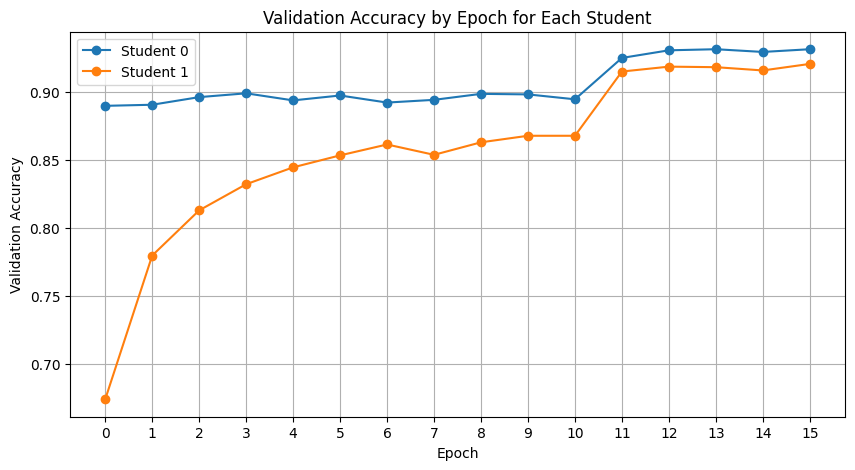

In [58]:
# Load the CSV file into a DataFrame
df = pd.read_csv('checkpoints_student/checkpoints_student_DML/results_student.csv')

# Filter data for each student
student_0 = df[df['Student ID'] == 0]
student_1 = df[df['Student ID'] == 1]

# Convert 'Epoch' column to integers
df['Epoch'] = df['Epoch'].astype(int)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(student_0['Epoch'], student_0['Valid Accuracy'], label='Student 0', marker='o')
plt.plot(student_1['Epoch'], student_1['Valid Accuracy'], label='Student 1', marker='o')
plt.title('Validation Accuracy by Epoch for Each Student')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.xticks(df['Epoch'].unique())  # Ensure all epochs are included in x-axis
plt.legend()
plt.grid(True)
plt.show()


### Result

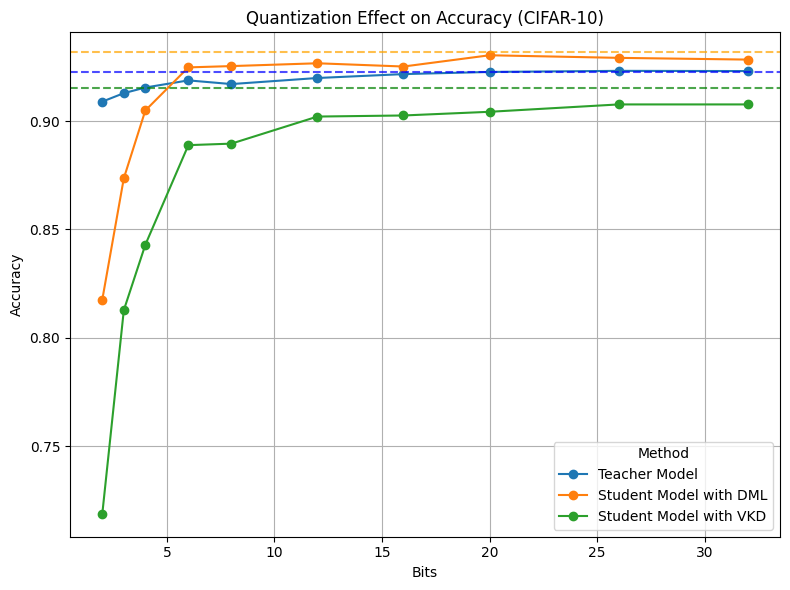

In [40]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")
quant_student_dml = pd.read_csv("checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv")
quant_student_van = pd.read_csv("checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv")

# Plot both lines sharing the same axes
plt.figure(figsize=(8, 6))
plt.plot(quant_teacher["Bits"], quant_teacher["Quantized Test Accuracy"], marker='o', label="Teacher Model")
plt.plot(quant_student_dml["Bits"], quant_student_dml["Quantized Test Accuracy"], marker='o', label="Student Model with DML")
plt.plot(quant_student_van["Bits"], quant_student_van["Quantized Test Accuracy"], marker='o', label="Student Model with VKD")

# Add horizontal lines for original accuracy
plt.axhline(y=0.9225, color='blue', linestyle='--', alpha=0.7)
plt.axhline(y=0.932, color='orange', linestyle='--', alpha=0.7)
plt.axhline(y=0.9152, color='green', linestyle='--', alpha=0.7)

# Add labels and title
plt.title("Quantization Effect on Accuracy (CIFAR-10)")
plt.xlabel("Bits")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Method", loc="best")

# Save the plot as PNG
plt.tight_layout()
plt.savefig('images/teacher_student_quant_acc_comparison.png', dpi=500)

# Show the plot
plt.show()

In [41]:
checkpoint = torch.load('checkpoints_student/checkpoints_student_VAN/student_epoch_19.pth')
van_student_net = networks.StudentNetwork(0.0, teacher_net = teacher_net)
van_student_net = student_net.to(fast_device)
van_student_net.load_state_dict(checkpoint)

utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

C:\Users\17598\AppData\Local\Temp\ipykernel_13896\774814024.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints_student/checkpoints_stud

(0.0, 0.9152)

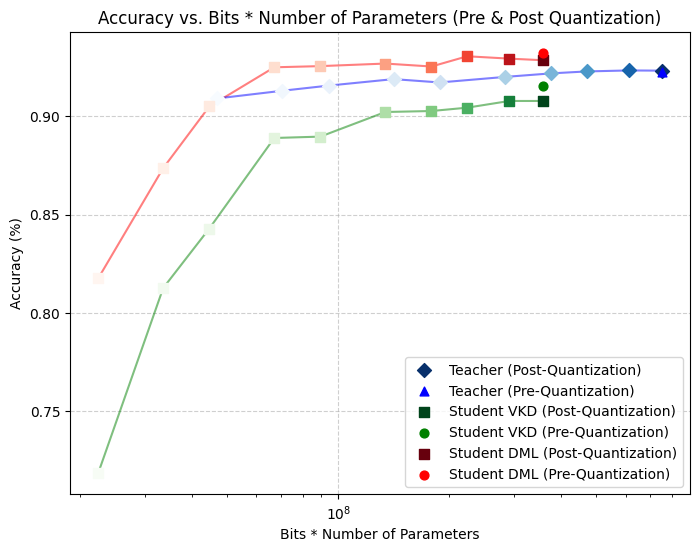

In [42]:
# Load the CSV files
quant_teacher = pd.read_csv("checkpoints_teacher/results_teacher_quantization.csv")
quant_student_dml = pd.read_csv("checkpoints_student/checkpoints_student_DML/results_student_quantization_dml.csv")
quant_student_van = pd.read_csv("checkpoints_student/checkpoints_student_VAN/results_student_quantization_van.csv")

num_parameter_teacher = count_parameters(teacher_net)
quant_teacher["Bits*Num_Parameter"] = quant_teacher['Bits'] * num_parameter_teacher

num_parameter_student = count_parameters(van_student_net)
quant_student_dml["Bits*Num_Parameter"] = quant_student_dml['Bits'] * num_parameter_student
quant_student_van["Bits*Num_Parameter"] = quant_student_van['Bits'] * num_parameter_student

# Define fixed colors for pre-quantization models
pre_student_color_dml = "red"
pre_student_color_van = "green"
pre_teacher_color = "blue"

# Define marker styles
marker_mapping = {
    "pre_student": "o",  # Circle for pre-quantization Student
    "post_student": "s",  # Square for post-quantization Student
    "pre_teacher": "^",  # Triangle for pre-quantization Teacher
    "post_teacher": "D"  # Diamond for post-quantization Teacher
}

# Scatter plots for pre and post-quantization
# Assumed that pre-quantization accuracy data is available; otherwise replace with actual data
pre_quantization_student_van_accuracy = 0.9152
pre_quantization_student_dml_accuracy = 0.932  # Example data
pre_quantization_teacher_accuracy = 0.9225  # Example data

pre_quantization_student_dml_bit_para = 357566784
pre_quantization_teacher_bit_para = 752666944

# Create colormap for bit precisions
cmap_student_dml = plt.cm.Reds
cmap_student_van = plt.cm.Greens
cmap_teacher = plt.cm.Blues
norm_student_dml = plt.Normalize(vmin=min(quant_student_dml['Bits*Num_Parameter']), vmax=max(quant_student_dml['Bits*Num_Parameter']))
norm_student_van = plt.Normalize(vmin=min(quant_student_van['Bits*Num_Parameter']), vmax=max(quant_student_van['Bits*Num_Parameter']))
norm_teacher = plt.Normalize(vmin=min(quant_teacher['Bits*Num_Parameter']), vmax=max(quant_teacher['Bits*Num_Parameter']))

# Define fixed colors for pre-quantization models
pre_student__dml_color = "red"
pre_student__van_color = "green"
pre_teacher_color = "blue"

# Define marker styles
marker_mapping = {
    "pre_student": "o",  # Circle for pre-quantization Student
    "post_student": "s",  # Square for post-quantization Student
    "pre_teacher": "^",  # Triangle for pre-quantization Teacher
    "post_teacher": "D"  # Diamond for post-quantization Teacher
}

fig, ax = plt.subplots(figsize=(8, 6))

# Plot Post-Quantization Student
ax.plot(quant_student_dml['Bits*Num_Parameter'], quant_student_dml['Quantized Test Accuracy'], 
        color='red', alpha=0.5, linestyle='-', linewidth=1.5)
ax.plot(quant_student_van['Bits*Num_Parameter'], quant_student_van['Quantized Test Accuracy'], 
        color='green', alpha=0.5, linestyle='-', linewidth=1.5)

# Plot Post-Quantization Teacher
ax.plot(quant_teacher['Bits*Num_Parameter'], quant_teacher['Quantized Test Accuracy'], 
        color='blue', alpha=0.5, linestyle='-', linewidth=1.5)


# Plot Post-Quantization points
for index, row in quant_teacher.iterrows():
    color_teacher = cmap_teacher(norm_teacher(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_teacher, marker=marker_mapping["post_teacher"], s=50, zorder = 10, label="Teacher (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_teacher_bit_para, pre_quantization_teacher_accuracy, 
           color=pre_teacher_color, marker=marker_mapping["pre_teacher"], label="Teacher (Pre-Quantization)", s=40, zorder = 10)

for index, row in quant_student_van.iterrows():
    color_student = cmap_student_van(norm_student_van(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_student, marker=marker_mapping["post_student"], s=50, zorder = 10, label="Student VKD (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_student_dml_bit_para, pre_quantization_student_van_accuracy, 
           color=pre_student_color_van, marker=marker_mapping["pre_student"], label="Student VKD (Pre-Quantization)", s=40, zorder = 10)
   
   
for index, row in quant_student_dml.iterrows():
    color_student = cmap_student_dml(norm_student_dml(row['Bits*Num_Parameter']))
    ax.scatter(row['Bits*Num_Parameter'], row['Quantized Test Accuracy'], 
               color=color_student, marker=marker_mapping["post_student"], s=50, zorder = 10, label="Student DML (Post-Quantization)" if index == 0 else "")
ax.scatter(pre_quantization_student_dml_bit_para, pre_quantization_student_dml_accuracy, 
           color=pre_student_color_dml, marker=marker_mapping["pre_student"], label="Student DML (Pre-Quantization)", s=40, zorder = 10)  


# Labels and title
plt.xlabel("Bits * Number of Parameters")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Bits * Number of Parameters (Pre & Post Quantization)")
plt.xscale("log")  # Using log scale for better parameter visualization
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
if not os.path.exists('images'):
    os.makedirs('images')
image_path = os.path.join('images', "quantization_effects.png")
plt.savefig(image_path, dpi=500)
plt.show()